# Day 3: XGBoost for Trading

## 🎯 Learning Objectives
- Understand gradient boosting theory
- Master XGBoost algorithm
- Apply regularization techniques
- Tune for financial data

---

## 📚 Theory: Gradient Boosting

### Boosting vs Bagging
| Bagging | Boosting |
|---------|----------|
| Parallel training | Sequential training |
| Reduce variance | Reduce bias |
| Equal weights | Weighted samples |
| Random Forest | XGBoost, LightGBM |

### Gradient Boosting Algorithm
1. Start with initial model $F_0(x)$
2. For m = 1 to M:
   - Compute pseudo-residuals: $r_i = -\frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)}$
   - Fit tree $h_m$ to residuals
   - Update: $F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$

### XGBoost Innovations
$$Obj = \sum_i L(y_i, \hat{y}_i) + \sum_k \Omega(f_k)$$

Where regularization:
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2$$

- $T$: Number of leaves
- $w_j$: Leaf weights
- $\gamma$: Complexity penalty
- $\lambda$: L2 regularization

### Key Parameters
- `learning_rate`: Step size shrinkage (0.01-0.3)
- `n_estimators`: Number of trees (100-1000)
- `max_depth`: Tree depth (3-10)
- `subsample`: Row sampling (0.5-1.0)
- `colsample_bytree`: Feature sampling (0.5-1.0)

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, roc_auc_score)
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
volume = data['Volume']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


In [2]:
# Create features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Momentum
for lag in [1, 5, 10, 20, 60]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

# Volatility
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

# Volume
df['volume_ratio'] = volume / volume.rolling(20).mean()

# MA ratios
df['ma_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1
df['ma_20_50'] = prices.rolling(20).mean() / prices.rolling(50).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# MACD
ema_12 = prices.ewm(span=12).mean()
ema_26 = prices.ewm(span=26).mean()
df['macd'] = (ema_12 - ema_26) / prices

# Target
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Features: {len([c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']])}, Samples: {len(df)}")

📊 Features: 13, Samples: 1193


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]
X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 954, Test: 239


In [4]:
# Basic XGBoost vs Random Forest
xgb_basic = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                          random_state=42, eval_metric='logloss')
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

xgb_basic.fit(X_train, y_train)
rf.fit(X_train, y_train)

print("\n" + "="*70)
print("XGBoost vs RANDOM FOREST")
print("="*70)

models = [('XGBoost', xgb_basic), ('Random Forest', rf)]

print(f"\n{'Model':<20} {'Train Acc':>12} {'Test Acc':>12} {'Test F1':>12}")
print("-" * 60)

for name, model in models:
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_f1 = f1_score(y_test, model.predict(X_test))
    print(f"{name:<20} {train_acc:>12.2%} {test_acc:>12.2%} {test_f1:>12.2%}")


XGBoost vs RANDOM FOREST

Model                   Train Acc     Test Acc      Test F1
------------------------------------------------------------
XGBoost                    98.74%       58.16%       61.24%
Random Forest              78.93%       57.32%       66.00%



EFFECT OF LEARNING RATE
 Learning Rate  Train Acc  Test Acc
          0.01   0.807128  0.514644
          0.05   0.986373  0.569038
          0.10   1.000000  0.564854
          0.20   1.000000  0.535565
          0.30   1.000000  0.548117


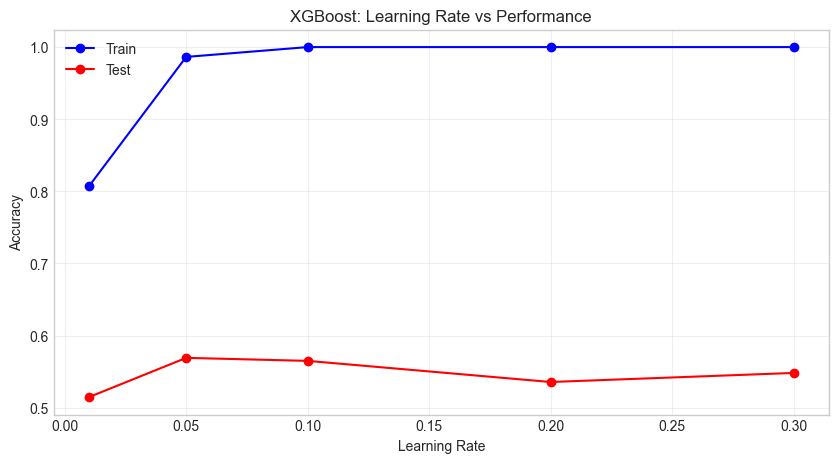

In [5]:
# Learning Rate Effect
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]

print("\n" + "="*70)
print("EFFECT OF LEARNING RATE")
print("="*70)

lr_results = []
for lr in learning_rates:
    xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=lr,
                       random_state=42, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    
    lr_results.append({
        'Learning Rate': lr,
        'Train Acc': accuracy_score(y_train, xgb.predict(X_train)),
        'Test Acc': accuracy_score(y_test, xgb.predict(X_test))
    })

lr_df = pd.DataFrame(lr_results)
print(lr_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(lr_df['Learning Rate'], lr_df['Train Acc'], 'b-o', label='Train')
plt.plot(lr_df['Learning Rate'], lr_df['Test Acc'], 'r-o', label='Test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('XGBoost: Learning Rate vs Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Regularization Effect
reg_params = [
    {'reg_alpha': 0, 'reg_lambda': 0, 'name': 'No Reg'},
    {'reg_alpha': 0.1, 'reg_lambda': 0, 'name': 'L1 Only'},
    {'reg_alpha': 0, 'reg_lambda': 1, 'name': 'L2 Only'},
    {'reg_alpha': 0.1, 'reg_lambda': 1, 'name': 'L1+L2'}
]

print("\n" + "="*70)
print("EFFECT OF REGULARIZATION")
print("="*70)

reg_results = []
for params in reg_params:
    xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                       reg_alpha=params['reg_alpha'], reg_lambda=params['reg_lambda'],
                       random_state=42, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    
    reg_results.append({
        'Regularization': params['name'],
        'Train Acc': accuracy_score(y_train, xgb.predict(X_train)),
        'Test Acc': accuracy_score(y_test, xgb.predict(X_test)),
        'Overfit Gap': accuracy_score(y_train, xgb.predict(X_train)) - accuracy_score(y_test, xgb.predict(X_test))
    })

reg_df = pd.DataFrame(reg_results)
print(reg_df.to_string(index=False))


EFFECT OF REGULARIZATION
Regularization  Train Acc  Test Acc  Overfit Gap
        No Reg   0.998952  0.569038     0.429914
       L1 Only   1.000000  0.527197     0.472803
       L2 Only   1.000000  0.564854     0.435146
         L1+L2   1.000000  0.560669     0.439331


In [7]:
# Full Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)
xgb_cv = XGBClassifier(random_state=42, eval_metric='logloss')

print("\n⏳ Running GridSearchCV...")
grid_search = GridSearchCV(xgb_cv, param_grid, cv=tscv, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"Best Parameters:")
for k, v in grid_search.best_params_.items():
    print(f"  {k}: {v}")
print(f"\nBest CV Score: {grid_search.best_score_:.4f}")

xgb_best = grid_search.best_estimator_


⏳ Running GridSearchCV...

GRID SEARCH RESULTS
Best Parameters:
  colsample_bytree: 1.0
  learning_rate: 0.05
  max_depth: 5
  n_estimators: 100
  subsample: 1.0

Best CV Score: 0.5785


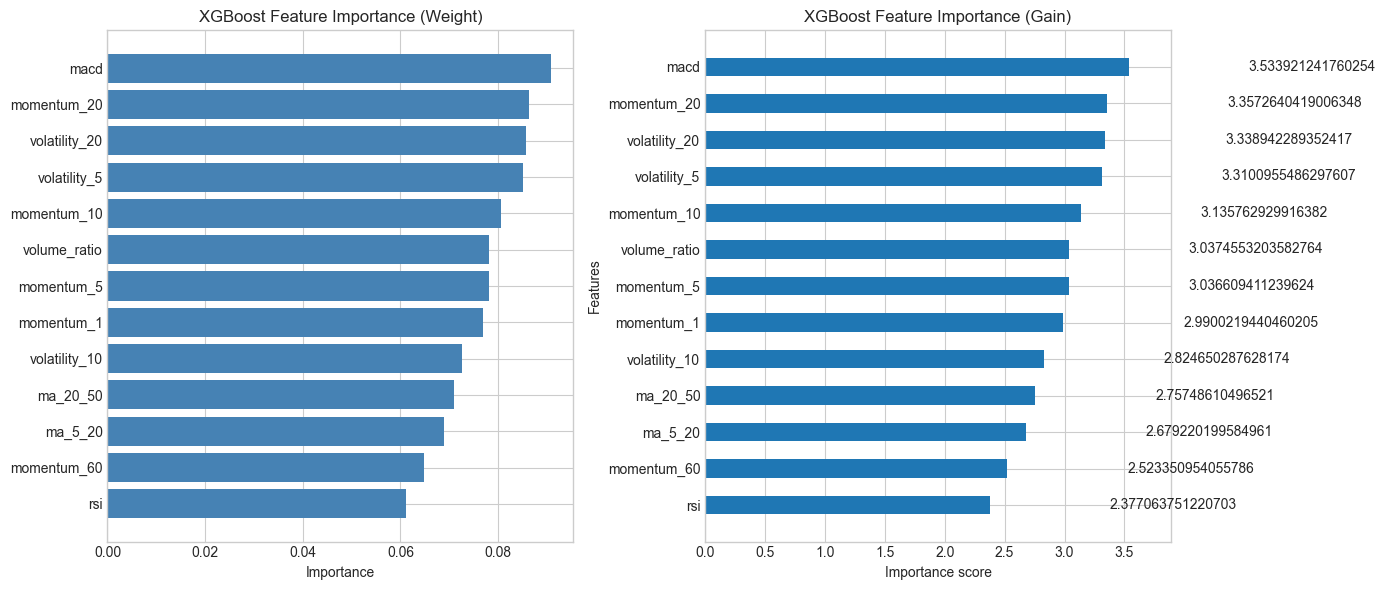

In [8]:
# Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Weight importance
importance_weight = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(importance_weight['Feature'], importance_weight['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('XGBoost Feature Importance (Weight)')

# Gain importance
plot_importance(xgb_best, importance_type='gain', ax=axes[1], height=0.5)
axes[1].set_title('XGBoost Feature Importance (Gain)')

plt.tight_layout()
plt.show()

In [9]:
# Early Stopping with Validation Set
val_split = int(len(X_train) * 0.8)
X_tr, X_val = X_train.iloc[:val_split], X_train.iloc[val_split:]
y_tr, y_val = y_train.iloc[:val_split], y_train.iloc[val_split:]

xgb_early = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.05,
                         random_state=42, eval_metric='logloss',
                         early_stopping_rounds=50)

xgb_early.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

print("\n" + "="*60)
print("EARLY STOPPING")
print("="*60)
print(f"Best iteration: {xgb_early.best_iteration}")
print(f"Best score: {xgb_early.best_score:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, xgb_early.predict(X_test)):.2%}")


EARLY STOPPING
Best iteration: 0
Best score: 0.6889
Test Accuracy: 52.30%


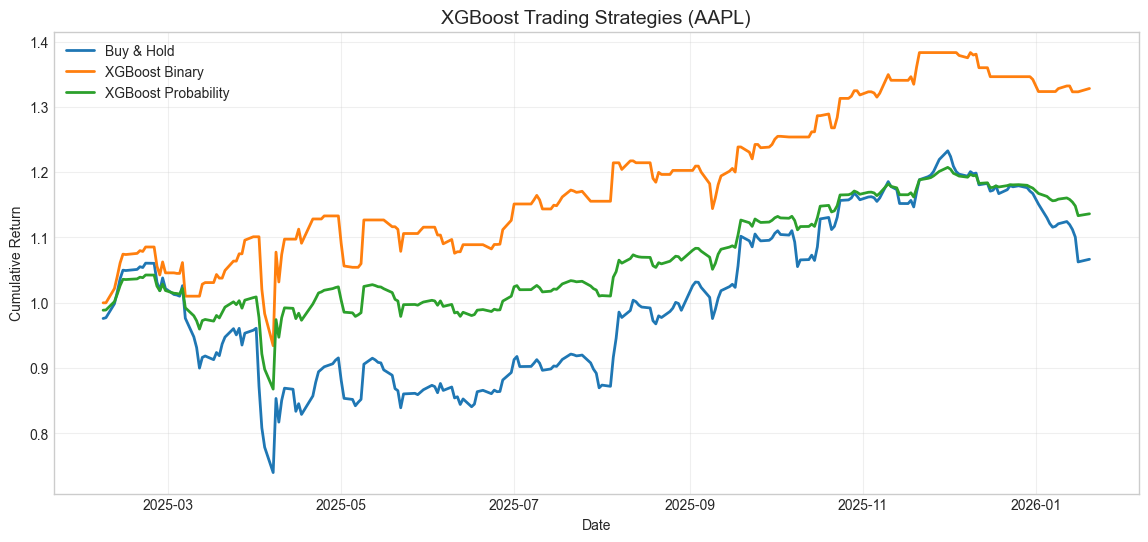

In [10]:
# Trading Strategy Backtest
y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:, 1]

backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

# Binary strategy
backtest['signal'] = y_pred
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']
backtest['strategy_cum'] = (1 + backtest['strategy_return']).cumprod()

# Probability weighted
backtest['prob_signal'] = y_proba
backtest['prob_return'] = backtest['prob_signal'] * backtest['actual_return']
backtest['prob_cum'] = (1 + backtest['prob_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label='XGBoost Binary', linewidth=2)
plt.plot(backtest.index, backtest['prob_cum'], label='XGBoost Probability', linewidth=2)
plt.title(f'XGBoost Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = [
    ('Buy & Hold', 'actual_return', 'buy_hold_cum'),
    ('XGBoost Binary', 'strategy_return', 'strategy_cum'),
    ('XGBoost Probability', 'prob_return', 'prob_cum')
]

print(f"\n{'Strategy':<25} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 60)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[cum_col])
    print(f"{name:<25} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                     Total Ret     Sharpe     Max DD
------------------------------------------------------------
Buy & Hold                       6.67%       0.21    -30.22%
XGBoost Binary                  32.81%       1.07    -15.14%
XGBoost Probability             13.63%       0.52    -16.75%


In [12]:
# Next day prediction
latest = X.iloc[-1:]
pred = xgb_best.predict(latest)[0]
proba = xgb_best.predict_proba(latest)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPrediction: {'📈 UP' if pred == 1 else '📉 DOWN'}")
print(f"Probability (Down/Up): [{proba[0]:.2%}, {proba[1]:.2%}]")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-20

Prediction: 📈 UP
Probability (Down/Up): [33.77%, 66.23%]


---

## 🏢 Real-World Applications

| Company | XGBoost Use Case |
|---------|------------------|
| Two Sigma | Signal generation |
| Citadel | Factor scoring |
| Jane Street | Market making signals |
| DE Shaw | Cross-asset predictions |

### Key Interview Points
1. **XGBoost vs RF?** - XGBoost uses sequential boosting, better bias reduction
2. **Regularization?** - L1/L2 on leaf weights, gamma on tree complexity
3. **Learning rate?** - Lower = more trees needed, but better generalization
4. **Early stopping?** - Prevents overfitting, must use validation set

---
## 📅 Tomorrow: LightGBM